## Observations and Insights 

# takeaway:
# 1. Mouse weight and average tumor volume for the Capomulin treatment are highly correlated. R=0.84
# 2.The line plot of tumor volume vs. time point for a mouse treated with Capomulin [l509,s185] :The graphs show positive treatment effect over time. While l509 tumor size tick up a bit later on, further investigation is needed.
# 3. Boxplot suggests Capomulin and Ramicane tend to perform better base on FinalTumor Volume, a side effect study may also required...baseline: we wanna make sure comparable amount of mice survive under these two treament rather than merely looking for final effect of Tumor treatment (Survivorship bias)

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress


# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
combinedf=pd.merge(mouse_metadata,study_results,how='outer',on="Mouse ID")
# Display the data table for preview
combinedf


,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


## check the number of mice

In [2]:
# Checking the number of mice.
combinedf.value_counts("Mouse ID")
#Note match 249 mice

Mouse ID
g989    13
a203    10
n364    10
m546    10
m550    10
        ..
x226     1
b447     1
f932     1
l872     1
n482     1
Length: 249, dtype: int64

In [3]:
combinedf.shape

(1893, 8)

In [4]:

resetcombinedf=combinedf.set_index("Mouse ID")
resetcombinedf


,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
Mouse ID,,,,,,,
k403,Ramicane,Male,21,16,0,45.000000,0
k403,Ramicane,Male,21,16,5,38.825898,0
k403,Ramicane,Male,21,16,10,35.014271,1
k403,Ramicane,Male,21,16,15,34.223992,1
k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...
z969,Naftisol,Male,9,30,25,63.145652,2
z969,Naftisol,Male,9,30,30,65.841013,3
z969,Naftisol,Male,9,30,35,69.176246,4


In [5]:
resetcombinedf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1893 entries, k403 to z969
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Drug Regimen        1893 non-null   object 
 1   Sex                 1893 non-null   object 
 2   Age_months          1893 non-null   int64  
 3   Weight (g)          1893 non-null   int64  
 4   Timepoint           1893 non-null   int64  
 5   Tumor Volume (mm3)  1893 non-null   float64
 6   Metastatic Sites    1893 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 118.3+ KB


In [6]:
resetcombinedf.columns


Index(['Drug Regimen', 'Sex', 'Age_months', 'Weight (g)', 'Timepoint',
       'Tumor Volume (mm3)', 'Metastatic Sites'],
      dtype='object')

In [7]:
from pandas_profiling import ProfileReport

In [8]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
#notice profiling hight light one duplicated rows exist
#fast easy way to use pre build function 
workingdf=combinedf.copy()
duplicatedFinding=workingdf.duplicated(["Mouse ID","Timepoint"],keep='first') # default is keep first
duplicatedFinding


0       False
1       False
2       False
3       False
4       False
        ...  
1888    False
1889    False
1890    False
1891    False
1892    False
Length: 1893, dtype: bool

### Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 

In [9]:
#pass series into list# further details ### we can flip the keep='last' to show the rest 5
listofduplicates=combinedf.loc[duplicatedFinding,:]
listofduplicates

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
909,g989,Propriva,Female,21,26,0,45.000000,0
911,g989,Propriva,Female,21,26,5,47.570392,0
913,g989,Propriva,Female,21,26,10,49.880528,0
915,g989,Propriva,Female,21,26,15,53.442020,0
917,g989,Propriva,Female,21,26,20,54.657650,1


In [10]:
#Alternative thought: isolated timestap if groupby timeid and timestap, ideally should be unique timepoit per id
#avoid any change point to parent df by copy()
workbench=resetcombinedf.copy().groupby(["Mouse ID","Timepoint"]).agg({"Timepoint":"count"})
#apply conidtion to filter out timepoint two count
duplicatedID=workbench.loc[workbench["Timepoint"]>1]
duplicatedID
#Mouse ID G989

Timepoint
Mouse ID Timepoint           
g989     0                  2
         5                  2
         10                 2
         15                 2
         20                 2

### Create a clean DataFrame by dropping the duplicate mouse by its ID.

In [11]:

#Drop the poluted data 
Nonduplicatedf=workingdf.set_index("Mouse ID").drop("g989")
Nonduplicatedf
#if we want keep one set of z989 data we can use drop_duplicates(.....keep="first")


,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
Mouse ID,,,,,,,
k403,Ramicane,Male,21,16,0,45.000000,0
k403,Ramicane,Male,21,16,5,38.825898,0
k403,Ramicane,Male,21,16,10,35.014271,1
k403,Ramicane,Male,21,16,15,34.223992,1
k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...
z969,Naftisol,Male,9,30,25,63.145652,2
z969,Naftisol,Male,9,30,30,65.841013,3
z969,Naftisol,Male,9,30,35,69.176246,4


#### parent df will be used as the base from now on


In [12]:
# Optional: Get all the data for the duplicate mouse ID. 
parentdf=Nonduplicatedf
parentdf
# parentdf will be use as the base data set for the rest of the study

,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
Mouse ID,,,,,,,
k403,Ramicane,Male,21,16,0,45.000000,0
k403,Ramicane,Male,21,16,5,38.825898,0
k403,Ramicane,Male,21,16,10,35.014271,1
k403,Ramicane,Male,21,16,15,34.223992,1
k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...
z969,Naftisol,Male,9,30,25,63.145652,2
z969,Naftisol,Male,9,30,30,65.841013,3
z969,Naftisol,Male,9,30,35,69.176246,4


## Checking the number of mice in the clean DataFrame.


In [13]:
parentdf.reset_index()["Mouse ID"].nunique()



248

# Summary Statistics

#### Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

#### Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
#### mean, median, variance, standard deviation, and SEM of the tumor volume. 
#### Assemble the resulting series into a single summary dataframe.

In [14]:
seriesmean=parentdf.groupby("Drug Regimen").mean()["Tumor Volume (mm3)"]
seriesmedian=parentdf.groupby("Drug Regimen").median()["Tumor Volume (mm3)"]
seriesVar=parentdf.groupby("Drug Regimen").var()["Tumor Volume (mm3)"]
seriesStd=parentdf.groupby("Drug Regimen").std()["Tumor Volume (mm3)"]
seriesSEM=parentdf.groupby("Drug Regimen").sem()["Tumor Volume (mm3)"]
combinedSumarrystatistics=pd.DataFrame({"mean":seriesmean,"median":seriesmedian,"var":seriesVar,"std":seriesStd,
                                       "sem":seriesSEM})
combinedSumarrystatistics


,mean,median,var,std,sem
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


#### Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

#### Using the aggregation method, produce the same summary statistics in a single line


In [15]:
sumarydf=parentdf.groupby("Drug Regimen").agg({"Tumor Volume (mm3)":["mean","median","var","std","sem"]})
sumarydf


Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin              52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol             52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril              55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol              54.331565  52.509285  66.173479  8.134708  0.596466
Placebo               54.033581  52.288934  61.168083  7.821003  0.581331
Propriva              52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane              40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn              54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol             53.236507  51.818479  48.533355  6.966589  0.516398

# Bar and Pie Charts

## Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas.



##### Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas.

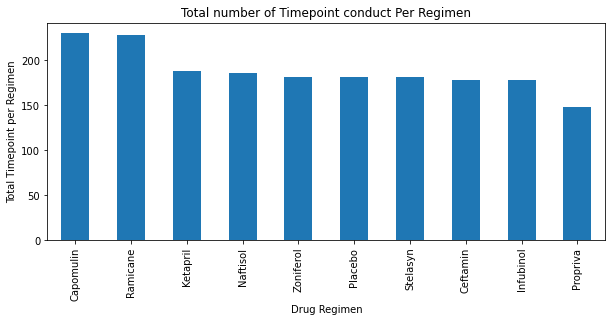

In [16]:
Totaltimepointsperdug=parentdf.reset_index().groupby(['Drug Regimen']).\
count()["Timepoint"].to_frame(name="Total Timepoints").sort_values("Total Timepoints",ascending=False)
graphbar1pandas=Totaltimepointsperdug.plot(kind='bar',figsize=(10,4),ylabel='Total Timepoint per Regimen',
                                     title="Total number of Timepoint conduct Per Regimen",legend=False)
#remove the legend by having False

Text(0.5, 1.0, 'Total number of Timepoint conduct Per Regimen')

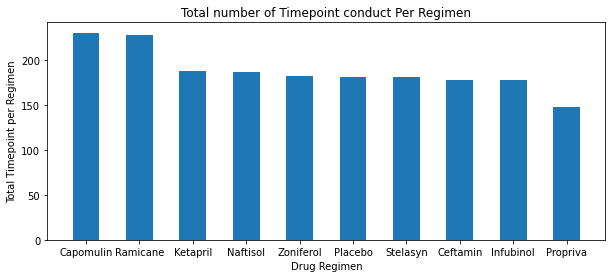

In [17]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using pyplot.
#figure size should be ahead of plot
x_axisname=Totaltimepointsperdug.index
plt.figure(figsize=(10,4))
graphbar2pyplot=plt.bar(x_axisname,Totaltimepointsperdug["Total Timepoints"],align='center',width=0.5)
plt.xlabel("Drug Regimen")
plt.ylabel("Total Timepoint per Regimen")
plt.title("Total number of Timepoint conduct Per Regimen")



## Generate a pie plot showing the distribution of female versus male mice using Pandas



(-1.101890831878222,
 1.1066254553600428,
 -1.1603876717544932,
 1.1066188864548543)

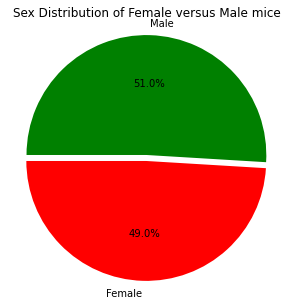

In [18]:
#Retrive raw data for plot
# pieplotdata=parentdf.groupby('Sex').count().to_frame()
plt.figure(figsize=(5,5))
pieplotdata=parentdf.reset_index().groupby('Sex').count()["Mouse ID"]
pieplotdata
graphtotaltimepointbygenderpandas=pieplotdata.plot(kind='pie',explode=[0.05,0],y="mice count by gender",
                                                      autopct='%1.1f%%',colors=['red','green'],
                                                   title='Sex Distribution of Female versus Male mice',startangle=180)
plt.ylabel("")
plt.axis('equal')


In [19]:
pieplotdata

Sex
Female    922
Male      958
Name: Mouse ID, dtype: int64

## Generate a pie plot showing the distribution of female versus male mice using pyplot

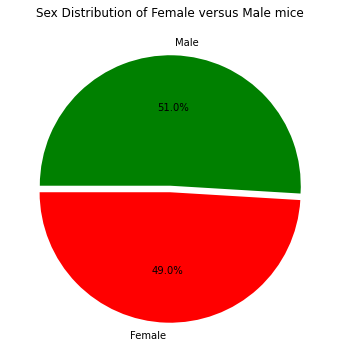

In [20]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
pielabels=pieplotdata.index
y_axispie=pieplotdata
pieplotdata
plt.figure(figsize=(6,6))
plt.title('Sex Distribution of Female versus Male mice')
graphtotaltimepointbygendermatplotlib=plt.pie(y_axispie,explode=[0.05,0],labels=pielabels,colors=['red','green'],
                                               autopct='%1.1f%%',shadow=False,startangle=180)


### Alternative thought: If we calculate per mouse distribution ;Note if the distribution base on per mouse data will be this; in case I am misunderstood

In [21]:
micebysexdf=parentdf.reset_index().drop_duplicates("Mouse ID",keep='first')
micebysexdf

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.0,0
10,s185,Capomulin,Female,3,17,0,45.0,0
20,x401,Capomulin,Female,16,15,0,45.0,0
30,m601,Capomulin,Male,22,17,0,45.0,0
40,g791,Ramicane,Male,11,16,0,45.0,0
...,...,...,...,...,...,...,...,...
1845,z314,Stelasyn,Female,21,28,0,45.0,0
1847,z435,Propriva,Female,12,26,0,45.0,0
1850,z581,Infubinol,Female,24,25,0,45.0,0
1860,z795,Naftisol,Female,13,29,0,45.0,0


In [22]:
micebysexdf

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.0,0
10,s185,Capomulin,Female,3,17,0,45.0,0
20,x401,Capomulin,Female,16,15,0,45.0,0
30,m601,Capomulin,Male,22,17,0,45.0,0
40,g791,Ramicane,Male,11,16,0,45.0,0
...,...,...,...,...,...,...,...,...
1845,z314,Stelasyn,Female,21,28,0,45.0,0
1847,z435,Propriva,Female,12,26,0,45.0,0
1850,z581,Infubinol,Female,24,25,0,45.0,0
1860,z795,Naftisol,Female,13,29,0,45.0,0


##### by pandas

(-1.1008166732185636,
 1.1032160400105204,
 -1.1559884692078919,
 1.1043388821189521)

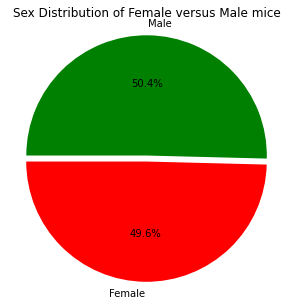

In [23]:
plt.figure(figsize=(5,5))
pieplotdataalter=micebysexdf.reset_index().groupby('Sex').count()["Mouse ID"]
pieplotdataalter
graphtotaltimepointbygenderpandas=pieplotdataalter.plot(kind='pie',explode=[0.05,0],y="mice count by gender",
                                                      autopct='%1.1f%%',colors=['red','green'],
                                                   title='Sex Distribution of Female versus Male mice',startangle=180)
plt.ylabel("")
plt.axis('equal')


#### by matplotlib

Text(0.5, 1.0, 'Sex Distribution of Female versus Male mice per Mouse')

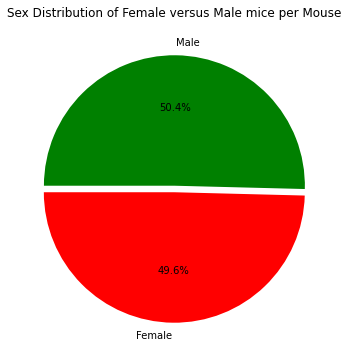

In [24]:
plotadataunique=micebysexdf.groupby('Sex').count()['Mouse ID']
pielabels=plotadataunique.index
y_axispie=plotadataunique.values
pieplotdata
plt.figure(figsize=(6,6))
graphtotaltimepointbygendermatplotlib=plt.pie(y_axispie,explode=[0.05,0],labels=pielabels,colors=['red','green'],
                                               autopct='%1.1f%%',shadow=False,startangle=180)
plt.title('Sex Distribution of Female versus Male mice per Mouse')


In [25]:
plotadataunique

Sex
Female    123
Male      125
Name: Mouse ID, dtype: int64

## Quartiles, Outliers and Boxplots

In [26]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse


# Merge this group df with the original dataframe to get the tumor volume at the last timepoint


In [27]:
parentdf

,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
Mouse ID,,,,,,,
k403,Ramicane,Male,21,16,0,45.000000,0
k403,Ramicane,Male,21,16,5,38.825898,0
k403,Ramicane,Male,21,16,10,35.014271,1
k403,Ramicane,Male,21,16,15,34.223992,1
k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...
z969,Naftisol,Male,9,30,25,63.145652,2
z969,Naftisol,Male,9,30,30,65.841013,3
z969,Naftisol,Male,9,30,35,69.176246,4


In [28]:
#to be efficient we reindex drug so we can pass the xlabel directly into df;# reset index to keep mouse
workbench2=parentdf.copy().reset_index().set_index("Drug Regimen").loc[["Capomulin","Ramicane","Infubinol","Ceftamin"]]
workbench2
#workbench 2 filter all 4 regimen related

,Mouse ID,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
Drug Regimen,,,,,,,
Capomulin,s185,Female,3,17,0,45.000000,0
Capomulin,s185,Female,3,17,5,43.878496,0
Capomulin,s185,Female,3,17,10,37.614948,0
Capomulin,s185,Female,3,17,15,38.177232,0
Capomulin,s185,Female,3,17,20,36.866876,0
...,...,...,...,...,...,...,...
Ceftamin,y865,Male,23,26,25,57.173538,2
Ceftamin,y865,Male,23,26,30,59.033275,3
Ceftamin,y865,Male,23,26,35,61.153140,3


In [29]:
beforemergeright=workbench2.reset_index().set_index(["Mouse ID","Timepoint"])
beforemergeright

Drug Regimen     Sex  Age_months  Weight (g)  \
Mouse ID Timepoint                                                
s185     0            Capomulin  Female           3          17   
         5            Capomulin  Female           3          17   
         10           Capomulin  Female           3          17   
         15           Capomulin  Female           3          17   
         20           Capomulin  Female           3          17   
...                         ...     ...         ...         ...   
y865     25            Ceftamin    Male          23          26   
         30            Ceftamin    Male          23          26   
         35            Ceftamin    Male          23          26   
         40            Ceftamin    Male          23          26   
         45            Ceftamin    Male          23          26   

                    Tumor Volume (mm3)  Metastatic Sites  
Mouse ID Timepoint                                        
s185     0                   45.000000                 0  
         5                   43.878496                 0  
         10                  37.614948                 0  
         15                  38.177232                 0  
         20                  36.866876                 0  
...                                ...               ...  
y865     25                  57.173538                 2  
         30                  59.033275                 3  
         35                  61.153140                 3  
         40                  63.469549                 3  
         45                  64.729837                 3  

[814 rows x 6 columns]

### Start by getting the last (greatest) timepoint for each mouse

In [30]:
beforemerge=workbench2.groupby(['Mouse ID']).agg({'Timepoint':max})
beforemerge

,Timepoint
Mouse ID,
a203,45
a251,45
a275,45
a411,45
a444,45
...,...
y769,45
y793,45
y865,45


In [31]:
indexx=np.arange(0,(len(beforemerge)),1)
indexx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

### Merge this group df with the original dataframe to get the tumor volume at the last timepoint
### use Mouse ID & Timepoint as composite key to inner merge filter final timepointonly

In [32]:
beforemerge=workbench2.groupby(['Mouse ID']).agg({'Timepoint':max})
beforemerge['helpercol']=indexx
readymergeleft=beforemerge.reset_index().set_index(['Mouse ID','Timepoint'])
finaldfforstats=pd.merge(beforemergeright,readymergeleft,how='inner',left_index=True,right_index=True)
finaldfforstats

,,Drug Regimen,Sex,Age_months,Weight (g),Tumor Volume (mm3),Metastatic Sites,helpercol
Mouse ID,Timepoint,,,,,,,
s185,45,Capomulin,Female,3,17,23.343598,1,70
x401,45,Capomulin,Female,16,15,28.484033,0,90
m601,45,Capomulin,Male,22,17,28.430964,1,51
f966,20,Capomulin,Male,16,17,30.485985,0,24
u364,45,Capomulin,Male,18,17,31.023923,3,78
...,...,...,...,...,...,...,...,...
x226,0,Ceftamin,Male,23,28,45.000000,0,89
x581,45,Ceftamin,Female,19,28,64.634949,3,91
x822,45,Ceftamin,Male,3,29,61.386660,3,92


In [33]:
finaldfforstats.reset_index().groupby("Drug Regimen").describe()["Tumor Volume (mm3)"]

,count,mean,std,min,25%,50%,75%,max
Drug Regimen,,,,,,,,
Capomulin,25.0,36.667568,5.715188,23.343598,32.377357,38.125164,40.159220,47.685963
Ceftamin,25.0,57.753977,8.365568,45.000000,48.722078,59.851956,64.299830,68.923185
Infubinol,25.0,58.178246,8.602957,36.321346,54.048608,60.165180,65.525743,72.226731
Ramicane,25.0,36.191390,5.671539,22.050126,31.560470,36.561652,40.659006,45.220869


In [34]:
parentdfwithmax=finaldfforstats
parentdfwithmax

,,Drug Regimen,Sex,Age_months,Weight (g),Tumor Volume (mm3),Metastatic Sites,helpercol
Mouse ID,Timepoint,,,,,,,
s185,45,Capomulin,Female,3,17,23.343598,1,70
x401,45,Capomulin,Female,16,15,28.484033,0,90
m601,45,Capomulin,Male,22,17,28.430964,1,51
f966,20,Capomulin,Male,16,17,30.485985,0,24
u364,45,Capomulin,Male,18,17,31.023923,3,78
...,...,...,...,...,...,...,...,...
x226,0,Ceftamin,Male,23,28,45.000000,0,89
x581,45,Ceftamin,Female,19,28,64.634949,3,91
x822,45,Ceftamin,Male,3,29,61.386660,3,92


In [35]:
parentdfwithmax.iloc[0,0]

'Capomulin'

In [36]:
# Add subset ,create an empty list
# Put treatments into a list for for loop (and later for plot labels)
# Create empty list to fill with tumor vol data (for plotting)
# Calculate the IQR and quantitatively determine if there are any potential outliers. 
# Locate the rows which contain mice on each drug and get the tumor volumes    
# add subset         
# Determine outliers using upper and lower bounds -->
# A DatFrame that has the last timepoint for each mouse ID is created using groupby. (5 points)
# The index of the DataFrame is reset. (2 points)
# Retrieve the maximum timepoint for each mouse. (2 points)
# The four treatment groups, Capomulin, Ramicane, Infubinol, and Ceftamin, are put in a list. (3 points)
# An empty list is created to fill with tumor volume data. (3 points)
# A for loop is used to display the interquartile range (IQR) and the outliers for each treatment group (10 points)
# A box plot is generated that shows the distribution of the final tumor volume for all the mice in each treatment group. (5 points)

In [37]:

loopdf=parentdfwithmax.reset_index()
treatmentname=["Capomulin", "Ramicane", "Infubinol","Ceftamin"]
tumorvolumedata=[]
indexreferencefortumor=[]
for x in treatmentname:
    for row in loopdf.index:
        #print(row)
        if loopdf.iloc[row,2]==x:
            tumorvolumedata.append(loopdf.iloc[row,6])
            indexreferencefortumor.append(x)
#outliersdataforprocess=pd.DataFrame({"treatment":indexreferencefortumor,"Tumor Volume (mm3)":tumorvolumedata})
quantileydata=list(zip(indexreferencefortumor,tumorvolumedata))
print(quantileydata)
# quantileydata[0][1]
# quantileydata[0]
# print(tumorvolumedata)
# print(indexreferencefortumor)


            

[('Capomulin', 23.34359787), ('Capomulin', 28.48403281), ('Capomulin', 28.43096411), ('Capomulin', 30.48598484), ('Capomulin', 31.02392294), ('Capomulin', 31.8962384), ('Capomulin', 32.37735684), ('Capomulin', 33.32909778), ('Capomulin', 34.45529799), ('Capomulin', 37.31184577), ('Capomulin', 36.04104736), ('Capomulin', 37.07402422), ('Capomulin', 38.84687569), ('Capomulin', 38.93963263), ('Capomulin', 38.98287774), ('Capomulin', 38.75326548), ('Capomulin', 38.1251644), ('Capomulin', 39.95234669), ('Capomulin', 40.65812366), ('Capomulin', 40.1592203), ('Capomulin', 40.72857787), ('Capomulin', 41.48300765), ('Capomulin', 41.58152074), ('Capomulin', 47.68596303), ('Capomulin', 46.53920617), ('Ramicane', 22.05012627), ('Ramicane', 29.12847181), ('Ramicane', 30.27623175), ('Ramicane', 30.56462509), ('Ramicane', 30.63869575), ('Ramicane', 31.56046955), ('Ramicane', 31.09533505), ('Ramicane', 33.39765251), ('Ramicane', 32.97852192), ('Ramicane', 33.56240217), ('Ramicane', 36.13485243), ('Ram

In [38]:
loopdf

,Mouse ID,Timepoint,Drug Regimen,Sex,Age_months,Weight (g),Tumor Volume (mm3),Metastatic Sites,helpercol
0,s185,45,Capomulin,Female,3,17,23.343598,1,70
1,x401,45,Capomulin,Female,16,15,28.484033,0,90
2,m601,45,Capomulin,Male,22,17,28.430964,1,51
3,f966,20,Capomulin,Male,16,17,30.485985,0,24
4,u364,45,Capomulin,Male,18,17,31.023923,3,78
...,...,...,...,...,...,...,...,...,...
95,x226,0,Ceftamin,Male,23,28,45.000000,0,89
96,x581,45,Ceftamin,Female,19,28,64.634949,3,91
97,x822,45,Ceftamin,Male,3,29,61.386660,3,92
98,y769,45,Ceftamin,Female,6,27,68.594745,4,95


In [39]:
#test out the locator
quantileydata[0][0]

'Capomulin'

### Calculate the final tumor volume of each mouse across four of the treatment regimens:  
### Capomulin, Ramicane, Infubinol, and Ceftamin

In [40]:
#loopthorugh find each drugs data
#create seprate list based on total regimen type in focus
#indexregimecounter as c; c represent seprate arry for each drug
# create a 2 dementional arry for loop
CapomulinList=[]
RamicaneList=[]
InfubinolList=[]
CeftaminList=[]
aggrelist=[CapomulinList,RamicaneList,InfubinolList,CeftaminList]
#counter c to relative two dementional index
c=0
for i in treatmentname:
    for x in range(len(quantileydata)):
        if quantileydata[x][0]==i:
            aggrelist[c].append(quantileydata[x][1])
        else:
            pass
    c=c+1
for arry in aggrelist:
    q1=np.quantile(arry,0.25)
    q3=np.quantile(arry,0.75)
    iQR=q3-q1
    lowerbound=q1-(1.5*iQR)
    upperbound=q3+(1.5*iQR)
    print(f"-----------------{treatmentname[aggrelist.index(arry)]}--------------------")
    print(f"IQR: {iQR}")
    print(f"min: {np.quantile(arry,0)}")
    print(f"lower: {np.quantile(arry,0.25)}")
    print(f"middle: {np.quantile(arry,0.50)}")
    print(f"uper: {np.quantile(arry,0.75)}")
    print(f"max: {np.quantile(arry,1.00)}")
    print(f"lowerbound: {lowerbound}")
    print(f"upperbound: {upperbound}")
    counter=0
    displayL=[]
    for value in arry:
        if (value<lowerbound) or (value>upperbound):
            counter+=1
            displayL.append(value)
    print(f"Total amt outlier:{counter}")
    print(f"List of outliervalue:{displayL}")

    if np.quantile(arry,0)< lowerbound:
            print(f"outlierlowest detected-----{np.quantile(arry,0)}----")
        
    if np.quantile(arry,1)>upperbound:
            print(f"outlierhighest detected-----{np.quantile(arry,1)}----")
    
    
     
     


    

-----------------Capomulin--------------------
IQR: 7.781863460000004
min: 23.34359787
lower: 32.37735684
middle: 38.1251644
uper: 40.1592203
max: 47.68596303
lowerbound: 20.70456164999999
upperbound: 51.83201549
Total amt outlier:0
List of outliervalue:[]
-----------------Ramicane--------------------
IQR: 9.098536719999998
min: 22.05012627
lower: 31.56046955
middle: 36.56165229
uper: 40.65900627
max: 45.22086888
lowerbound: 17.912664470000003
upperbound: 54.30681135
Total amt outlier:0
List of outliervalue:[]
-----------------Infubinol--------------------
IQR: 11.477135160000003
min: 36.3213458
lower: 54.04860769
middle: 60.16518046
uper: 65.52574285
max: 72.2267309
lowerbound: 36.83290494999999
upperbound: 82.74144559000001
Total amt outlier:1
List of outliervalue:[36.3213458]
outlierlowest detected-----36.3213458----
-----------------Ceftamin--------------------
IQR: 15.577752179999997
min: 45.0
lower: 48.72207785
middle: 59.85195552
uper: 64.29983003
max: 68.92318457
lowerbound: 25

In [41]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest


([<matplotlib.axis.XTick at 0x1ff70aba430>,
 [Text(1, 0, 'Capomulin'),
  Text(2, 0, 'Ramicane'),
  Text(3, 0, 'Infubinol'),
  Text(4, 0, 'Ceftamin')])

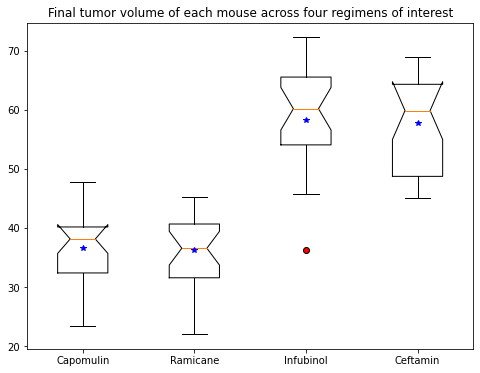

In [42]:
# pass the arry into this graph
#notice multiple graph have use plt.xticks instead of xlabels and pass through is in form of list(can not be array/series)
plt.figure(figsize=(8,6))
red_circle=dict(markerfacecolor='red',marker='o')
mean_marker=dict(markerfacecolor='blue',marker='*',markeredgecolor='blue')
boxplotgraph=plt.boxplot(aggrelist,flierprops=red_circle,showmeans=True, meanprops=mean_marker,notch=True)
plt.title('Final tumor volume of each mouse across four regimens of interest')
# plt.xtickslabel("Capomulin", "Ramicane","Infubinol","Ceftamin")
#configure the grpha
# add x_aix label
x_aix=np.arange(1,(len(treatmentname)+1),1).tolist()
plt.xticks(x_aix,treatmentname,rotation='horizontal')


## Line and Scatter Plots

In [43]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin


In [44]:
allCapomulin=combinedf.set_index("Drug Regimen").loc['Capomulin']
lineplotdata=allCapomulin.set_index('Mouse ID').loc['s185'].set_index('Timepoint')['Tumor Volume (mm3)']
lineplotdata

Timepoint
0     45.000000
5     43.878496
10    37.614948
15    38.177232
20    36.866876
25    33.949940
30    32.959671
35    28.328531
40    25.472143
45    23.343598
Name: Tumor Volume (mm3), dtype: float64

#### My own Mouse pick Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin

<AxesSubplot:title={'center':'Capomulin treament of Mouse <S185>'}, xlabel='Timepoint', ylabel='Tumor Volume (mm3)'>

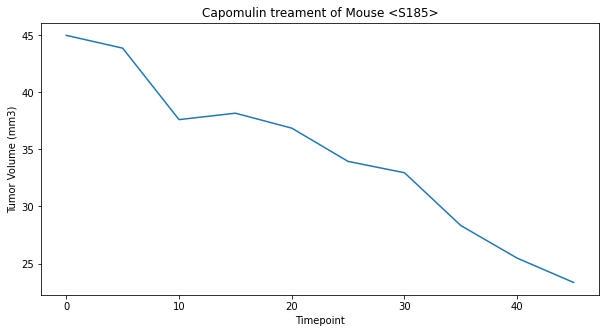

In [45]:
plt.figure(figsize=(10,5))
plt.ylabel("Tumor Volume (mm3)")
plt.title("Capomulin treament of Mouse <S185>")
lineplotdata.plot(kind='line')

#### To match the data required

<AxesSubplot:title={'center':'Capomulin treament of Mouse <l509>'}, xlabel='Timepoint', ylabel='Tumor Volume (mm3)'>

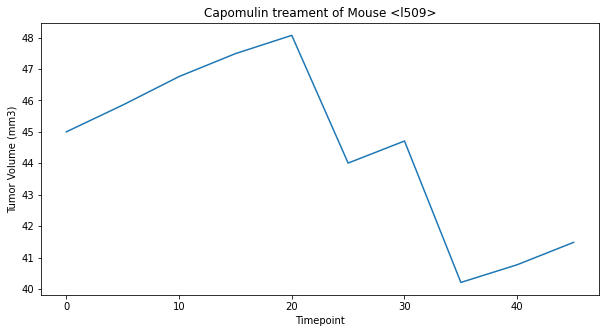

In [46]:
lineplotdata2=allCapomulin.set_index('Mouse ID').loc['l509'].set_index('Timepoint')['Tumor Volume (mm3)']
lineplotdata2
plt.figure(figsize=(10,5))
plt.ylabel("Tumor Volume (mm3)")
plt.title("Capomulin treament of Mouse <l509>")
lineplotdata2.plot(kind='line')

#### Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen


In [47]:
retrivedscatterplotdata=allCapomulin.groupby(["Mouse ID","Weight (g)"]).agg({"Tumor Volume (mm3)":'mean'}).reset_index()
#note need to reindex in order to retirve the series


Text(0.5, 1.0, 'Tumor volume vs. mouse weight for the Capomulin regimen')

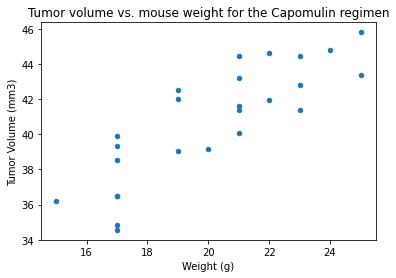

In [48]:

retrivedscatterplotdata.plot(kind='scatter',x='Weight (g)',y='Tumor Volume (mm3)')
plt.title('Tumor volume vs. mouse weight for the Capomulin regimen')

## Correlation and Regression

###### Calculate the correlation coefficient and linear regression model between mouse weight and average tumor volume for the Capomulin treatment

Text(0.5, 1.0, 'Tumor volume vs. mouse weight for the Capomulin regimen')

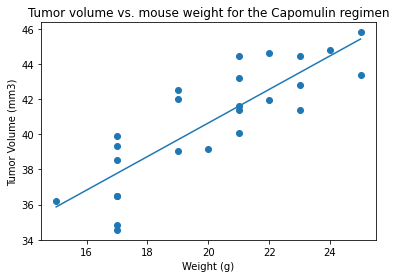

In [49]:
# use subplot method to create the graph
weight=retrivedscatterplotdata['Weight (g)'].tolist()
avgTumorVol=retrivedscatterplotdata['Tumor Volume (mm3)'].tolist()
fig,ax=plt.subplots()
ax.scatter(weight,avgTumorVol)
lin_out=st.linregress(weight,avgTumorVol)
lin_out
slope,interc,r,p,stderr=lin_out
x_fit=np.linspace(np.min(weight),np.max(weight))
y_fit=x_fit*slope+interc
ax.plot(x_fit,y_fit)
plt.xlabel('Weight (g)')
plt.ylabel('Tumor Volume (mm3)')
plt.title('Tumor volume vs. mouse weight for the Capomulin regimen')



In [50]:
lin_out=st.linregress(weight,avgTumorVol)
lin_out

LinregressResult(slope=0.9544396890241049, intercept=21.552160532685008, rvalue=0.8419363424694721, pvalue=1.3225722434712404e-07, stderr=0.12754359033201323, intercept_stderr=2.5909876867683455)

In [51]:
# calculate R square
Rsquare=r**2
print(f"rsquare= {Rsquare}")

rsquare= 0.7088568047708723


In [52]:
#otherway to do 
correlation=st.pearsonr(weight,avgTumorVol)
correlation[0]

0.841936342469472

In [53]:

"Y="+str(round(slope,2))+"X+"+str(round(interc,2))

'Y=0.95X+21.55'

In [54]:
#add math expression

$y=0.95x+22$

### Correlation as required below

In [55]:
r

0.8419363424694721

##### confrim vai following method

In [56]:
retrivedscatterplotdata.corr(method='pearson')

,Weight (g),Tumor Volume (mm3)
Weight (g),1.000000,0.841936
Tumor Volume (mm3),0.841936,1.000000
